In [1]:
import random
import os
import torch
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import lognorm
from scipy import stats # Import the scipy.stats module
import numpy as np
import logging
import sys
from sdo.datasets.sdo_dataset import SDO_Dataset
from torch.utils.data import DataLoader
import pandas as pd
import statistics 
from statistics import mode 

notebook_name = '01_MJ_Baseline_for_AutoCal'

## Loading the data

In [2]:
#just a way to get nice logging messages from the sdo package
logformat = "[%(asctime)s] %(levelname)s:%(name)s:%(message)s"
#logging.basicConfig(level=logging.DEBUG, stream=sys.stdout, format=logformat, datefmt="%Y-%m-%d %H:%M:%S") 
logging.basicConfig(level=logging.WARNING, stream=sys.stdout, format=logformat, datefmt="%Y-%m-%d %H:%M:%S") 

In [3]:
subsample = 1
original_ratio = 512
img_shape = int(original_ratio/subsample)
instr = ['AIA','AIA','AIA','AIA','AIA','AIA','AIA','HMI'] #RED FLAG: Insert HMI as the first instrument in the 'instr'.
channels = ['0094','0131','0171','0193','0211','0304','0335','bz']#RED FLAG: Insert HMI as the first channel in the 'channels'.

In [4]:
#Loading datasets with the latest SDO_Datset
data = SDO_Dataset(instr=instr, channels=channels, yr_range=[2012, 2013], #experiment 1
#data = SDO_Dataset(instr=instr, channels=channels, yr_range=[2010, 2011], #experiment 2
                         mnt_step=1, day_step=1, h_step=6, min_step=60,
                         subsample=subsample, 
                         normalization=0, scaling=False, test=True)
batch_size = data.__len__()*len(channels) # Loading the number of images = files*channels
loader= DataLoader(data,batch_size=batch_size, shuffle=False) 

In [5]:
#The loop below is used to load the data from the data loader.
for batch_idx, (input_data) in enumerate(loader):
    input_data = input_data.numpy()

In [6]:
#Checking the min and max values per channel
for ch in range(len(channels)-1): #For each time, iterate over the AIA channels. The last channel is HMI so len(channels)-1.
    print("Channel ", ch)
    print("Min of channel", ch, "=", np.min(input_data[:,ch,:,:]))
    print("Max of channel", ch, "=", np.max(input_data[:,ch,:,:]))

Channel  0
Min of channel 0 = 0.0
Max of channel 0 = 8886.526
Channel  1
Min of channel 1 = 0.0
Max of channel 1 = 18952.775
Channel  2
Min of channel 2 = 0.0
Max of channel 2 = 67829.984
Channel  3
Min of channel 3 = 0.0
Max of channel 3 = 105559.016
Channel  4
Min of channel 4 = 0.0
Max of channel 4 = 27070.533
Channel  5
Min of channel 5 = 0.0
Max of channel 5 = 112121.21
Channel  6
Min of channel 6 = 0.0
Max of channel 6 = 11267.334


## Make cutouts

In [7]:
dimension_input_data = input_data.shape
xposmin=np.int(original_ratio/(4*subsample))
xposmax=np.int(original_ratio/(4*subsample)) + np.int(original_ratio/(2.*subsample))
yposmin=np.int(original_ratio/(4*subsample))
yposmax=np.int(original_ratio/(4*subsample)) + np.int(original_ratio/(2.*subsample))
roi_cut_out=[xposmin,xposmax,yposmin,yposmax] # Avoiding the limb of the Sun.

In [8]:
mag_threshold = 5. # This is the magnetic field strength in Gauss, above which we mask all the pixels with 0 value, rest are 1.
alpha_pred = np.zeros([dimension_input_data[0]-1,7])
alpha_gt = np.zeros([dimension_input_data[0]-1,7])

In [9]:
#Things to potentially change
intensity_range=[1,30000] # This is used to consider a fixed ranged of intensity distribution across all channels
t_index = 0 #(change to 100 )
xlimit = [30,100,3000,4000,2000,1000,100]

## Reference

In [10]:
#compute the most probable value for the first image (ground truth) once and iterate over the dimmed. 
mask_qs_reference=np.zeros((256,256),dtype=float)
most_probable_value_ref=np.zeros([7])


input_cut_out_reference=input_data[t_index,:,roi_cut_out[0]:roi_cut_out[1],roi_cut_out[2]:roi_cut_out[3]] #Index =0 i.e. time=0
indices_threshold_reference =np.where(np.abs(input_cut_out_reference[7,:,:]) <= mag_threshold)
mask_qs_reference[indices_threshold_reference[0],indices_threshold_reference[1]]=1 # Setting the pixels for the QS to 1

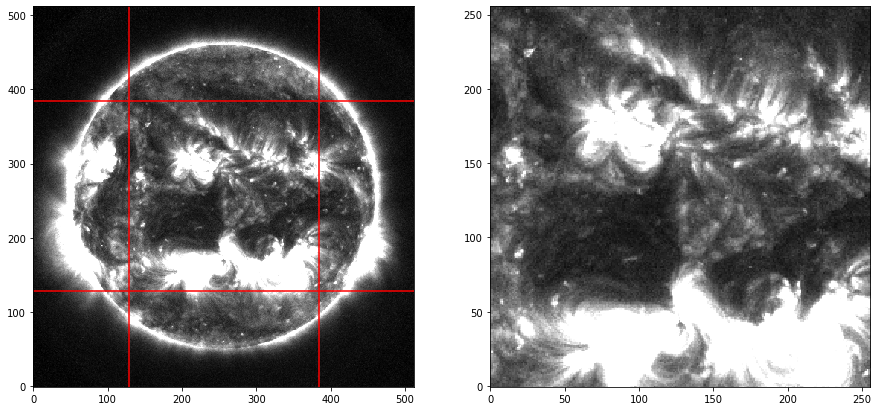

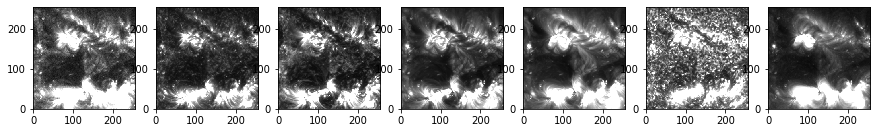

In [11]:
a = input_data[t_index,0,:,:]
b = input_cut_out_reference[0,:,:]
b1 = input_cut_out_reference[1,:,:]
b2 = input_cut_out_reference[2,:,:]
b3 = input_cut_out_reference[3,:,:]
b4 = input_cut_out_reference[4,:,:]
b5 = input_cut_out_reference[5,:,:]
b6 = input_cut_out_reference[6,:,:]

figsize=(15,15)
fig, ax = plt.subplots(1, 2, figsize=figsize, sharey=False)
ax[0].imshow(a, cmap='gray',clim=(0,10),origin='lower')
ax[0].axvline(x=xposmin, color='red')
ax[0].axvline(x=xposmax, color='red')
ax[0].axhline(y=yposmin, color='red')
ax[0].axhline(y=yposmax, color='red')
ax[1].imshow(b, cmap='gray',clim=(0,10), origin='lower')


fig, ax = plt.subplots(1, 7, figsize=figsize, sharey=False)
ax[0].imshow(b, cmap='gray',clim=(0,10),origin='lower')
ax[1].imshow(b1, cmap='gray',clim=(0,80), origin='lower')
ax[2].imshow(b2, cmap='gray',clim=(0,2000), origin='lower')
ax[3].imshow(b3, cmap='gray',clim=(0,3000), origin='lower')
ax[4].imshow(b4, cmap='gray',clim=(0,1000), origin='lower')
ax[5].imshow(b5, cmap='gray',clim=(0,500), origin='lower')
ax[6].imshow(b6, cmap='gray',clim=(0,80), origin='lower')


In [12]:
#Checking the min and max values per channel for the cutout images
for ch in range(len(channels)-1): #For each time, iterate over the AIA channels. The last channel is HMI so len(channels)-1.
    print("Channel ", ch)
    print("Min of channel", ch, "=", np.min(input_cut_out_reference[ch,:,:]))
    print("Max of channel", ch, "=", np.max(input_cut_out_reference[ch,:,:]))

Channel  0
Min of channel 0 = 0.1990583
Max of channel 0 = 66.218956
Channel  1
Min of channel 1 = 2.852966
Max of channel 1 = 513.31104
Channel  2
Min of channel 2 = 95.44607
Max of channel 2 = 10793.024
Channel  3
Min of channel 3 = 136.61926
Max of channel 3 = 10416.35
Channel  4
Min of channel 4 = 41.06979
Max of channel 4 = 5104.669
Channel  5
Min of channel 5 = 55.02361
Max of channel 5 = 2838.0564
Channel  6
Min of channel 6 = 2.3032937
Max of channel 6 = 468.4159


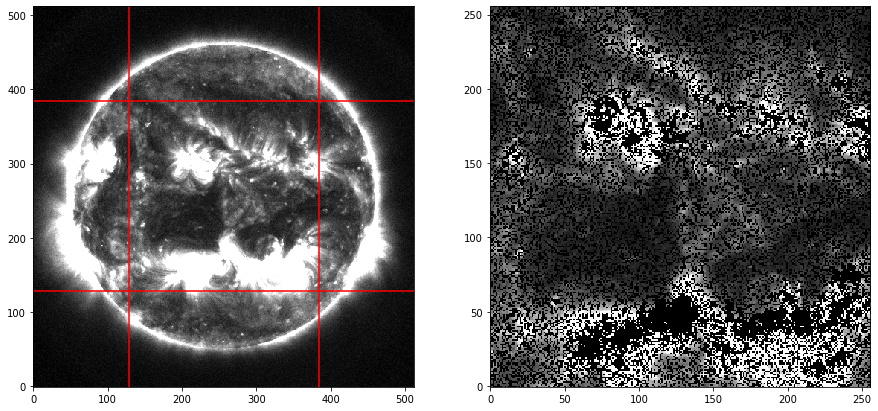

In [14]:
quiet_sun_mask = mask_qs_reference*input_cut_out_reference[0,:,:].copy()
indices_no_zero = np.where(quiet_sun_mask>1) #Considering the pixels without the zeros.
b_masked = input_cut_out_reference[0,indices_no_zero[0],indices_no_zero[1]]
b = input_cut_out_reference[0,:,:]

figsize=(15,15)
fig, ax = plt.subplots(1, 2, figsize=figsize, sharey=False)
ax[0].imshow(a, cmap='gray',clim=(0,10),origin='lower')
ax[0].axvline(x=xposmin, color='red')
ax[0].axvline(x=xposmax, color='red')
ax[0].axhline(y=yposmin, color='red')
ax[0].axhline(y=yposmax, color='red')
ax[1].imshow(quiet_sun_mask, cmap='gray',clim=(0,10), origin='lower')


Histograms of all input_cut_out_reference
channel 0 min = 0.1990583 max =  66.218956
channel 1 min = 2.852966 max =  513.31104
channel 2 min = 95.44607 max =  10793.024
channel 3 min = 136.61926 max =  10416.35
channel 4 min = 41.06979 max =  5104.669
channel 5 min = 55.02361 max =  2838.0564
channel 6 min = 2.3032937 max =  468.4159
Histograms of cut-out + imposing pixels >1 of input_cut_out_reference
channel 0 min = 1.0000042 max =  66.218956
channel 1 min = 2.852966 max =  513.31104
channel 2 min = 95.44607 max =  10793.024
channel 3 min = 136.61926 max =  10416.35
channel 4 min = 41.06979 max =  5104.669
channel 5 min = 55.02361 max =  2838.0564
channel 6 min = 2.3032937 max =  468.4159
Histograms of QS only, input_cut_out_reference
channel 0 min = 0.0 max =  44.002506256103516
channel 1 min = 0.0 max =  203.6538543701172
channel 2 min = 0.0 max =  6642.212890625
channel 3 min = 0.0 max =  7519.97509765625
channel 4 min = 0.0 max =  3527.514892578125
channel 5 min = 0.0 max =  2487

Text(0.5, 0.98, 'Log-Histograms of QS only, imposing pixels >1 of input_cut_out_reference')

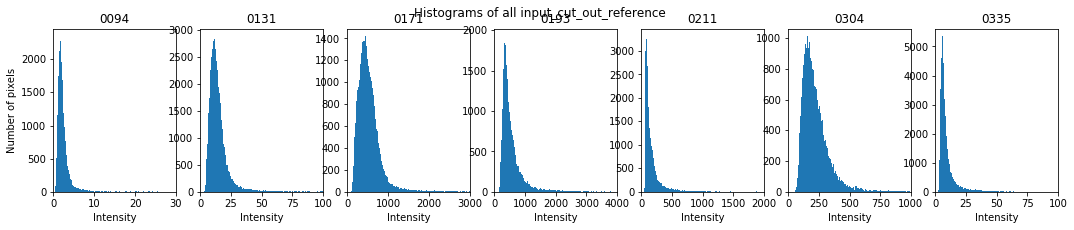

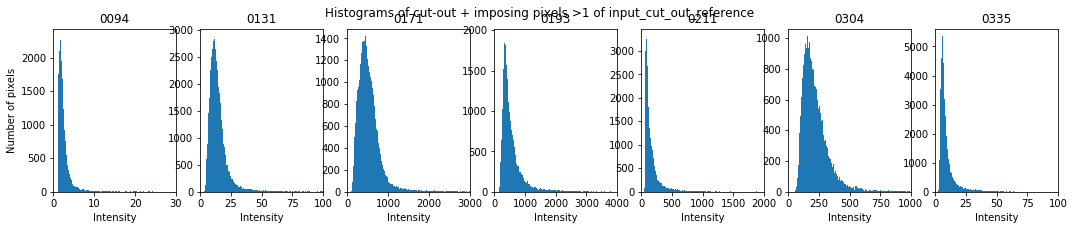

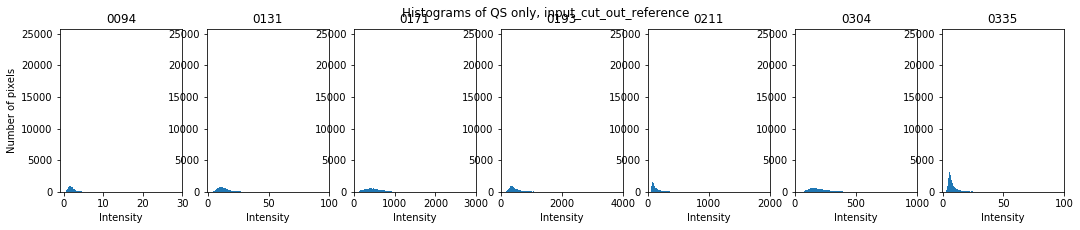

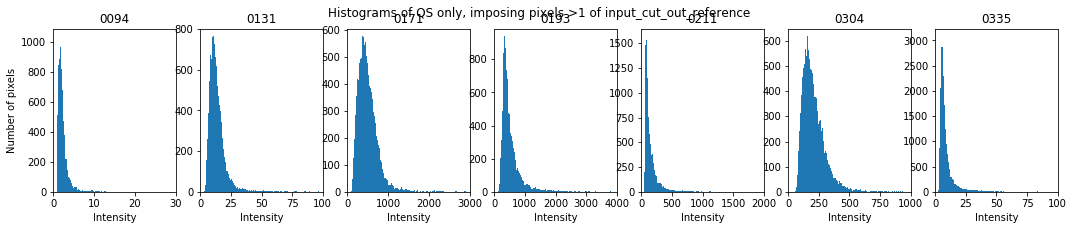

In [ ]:
#Checking the histograms
import pandas as pd

print('Histograms of all input_cut_out_reference')
#fig, ax = plt.subplots(1, 7, figsize=(18,3), sharey=True)
fig, ax = plt.subplots(1, 7, figsize=(18,3), sharey=False)
for ch in range(len(channels)-1): #For each time, iterate over the AIA channels. The last channel is HMI so len(channels)-1.
    AIA_reference = input_cut_out_reference[ch,:,:].copy()
    print('channel',ch,'min =', np.min(AIA_reference), 'max = ', np.max(AIA_reference))
    ax[ch].set_title(channels[ch])
    ax[ch].hist(x=pd.Series(np.ravel(AIA_reference)), bins=1000)
    ax[ch].set_xlabel('Intensity')
    ax[ch].set_xlim([0,xlimit[ch]])
    ax[0].set_ylabel('Number of pixels');
fig.suptitle('Histograms of all input_cut_out_reference')
    
print('Histograms of cut-out + imposing pixels >1 of input_cut_out_reference')
fig, ax = plt.subplots(1, 7, figsize=(18,3), sharey=False)
for ch in range(len(channels)-1): #For each time, iterate over the AIA channels. The last channel is HMI so len(channels)-1.
    AIA_reference = input_cut_out_reference[ch,:,:].copy()
    indices_no_zero_2 = np.where(AIA_reference>1) #Considering the pixels without the zeros.
    print('channel',ch,'min =', np.min(AIA_reference[indices_no_zero_2[0],indices_no_zero_2[1]]), 'max = ', np.max(AIA_reference))
    ax[ch].set_title(channels[ch])
    ax[ch].hist(x=pd.Series(np.ravel(AIA_reference[indices_no_zero_2[0],indices_no_zero_2[1]])), bins=1000)
    ax[ch].set_xlabel('Intensity')
    ax[ch].set_xlim([0,xlimit[ch]])
    ax[0].set_ylabel('Number of pixels');
fig.suptitle('Histograms of cut-out + imposing pixels >1 of input_cut_out_reference')

print('Histograms of QS only, input_cut_out_reference')
fig, ax = plt.subplots(1, 7, figsize=(18,3), sharey=False)
for ch in range(len(channels)-1): #For each time, iterate over the AIA channels. The last channel is HMI so len(channels)-1.
    quiet_sun_AIA_reference_test = mask_qs_reference*input_cut_out_reference[ch,:,:].copy()
    print('channel',ch,'min =', np.min(quiet_sun_AIA_reference_test ), 'max = ', np.max(quiet_sun_AIA_reference_test ))
    ax[ch].set_title(channels[ch])
    ax[ch].hist(x=pd.Series(np.ravel(quiet_sun_AIA_reference_test)), bins=1000)
    ax[ch].set_xlabel('Intensity')
    ax[ch].set_xlim([-1,xlimit[ch]])
    ax[0].set_ylabel('Number of pixels');
fig.suptitle('Histograms of QS only, input_cut_out_reference')
    
    

print('Histograms of QS only, imposing pixels >1 of input_cut_out_reference')
fig, ax = plt.subplots(1, 7, figsize=(18,3), sharey=False)
for ch in range(len(channels)-1): #For each time, iterate over the AIA channels. The last channel is HMI so len(channels)-1.
    quiet_sun_AIA_reference = mask_qs_reference*input_cut_out_reference[ch,:,:].copy()
    indices_no_zero = np.where(quiet_sun_AIA_reference>1) #Considering the pixels without the zeros.
    print('channel',ch,'min =', np.min(quiet_sun_AIA_reference[indices_no_zero[0],indices_no_zero[1]]), 'max = ', np.max(quiet_sun_AIA_reference[indices_no_zero[0],indices_no_zero[1]]))
    ax[ch].set_title(channels[ch])
    ax[ch].hist(x=pd.Series(np.ravel(quiet_sun_AIA_reference[indices_no_zero[0],indices_no_zero[1]])), bins=1000)
    ax[ch].set_xlabel('Intensity')
    ax[ch].set_xlim([0,xlimit[ch]])
    ax[0].set_ylabel('Number of pixels');
fig.suptitle('Histograms of QS only, imposing pixels >1 of input_cut_out_reference')

    
fig, ax = plt.subplots(1, 7, figsize=(18,3), sharey=False)
for ch in range(len(channels)-1): #For each time, iterate over the AIA channels. The last channel is HMI so len(channels)-1.
    quiet_sun_AIA_reference = mask_qs_reference*input_cut_out_reference[ch,:,:].copy()
    indices_no_zero = np.where(quiet_sun_AIA_reference>1) #Considering the pixels without the zeros.
    ax[ch].set_title(channels[ch])
    ax[ch].hist(x=pd.Series(np.log(np.ravel(quiet_sun_AIA_reference[indices_no_zero[0],indices_no_zero[1]]))), bins=1000)
    ax[ch].set_xlabel('Intensity')
    ax[0].set_ylabel('Number of pixels');
#    ax[ch].set_xlim([0,xlimit[ch]])
fig.suptitle('Log-Histograms of QS only, imposing pixels >1 of input_cut_out_reference')



Histograms overlaid with most frequent values found with argmax
channel 0 max =  32.6622428894043
32.6622428894043
b= 0 bins_num= 50
where is the most frequent value 1
what is the most frequent value 1.6332459092140197
b= 1 bins_num= 200
where is the most frequent value 3
what is the most frequent value 1.4749347001314164
b= 2 bins_num= 500
where is the most frequent value 9
what is the most frequent value 1.5699214255809784
b= 3 bins_num= 1000
where is the most frequent value 23
what is the most frequent value 1.728232634663582
b= 4 bins_num= 3000
where is the most frequent value 55
what is the most frequent value 1.5804755061864852
channel 1 max =  239.29876708984375
239.29876708984375
b= 0 bins_num= 50
where is the most frequent value 1
what is the most frequent value 7.079911255836487
b= 1 bins_num= 200
where is the most frequent value 6
what is the most frequent value 9.449491417407991
b= 2 bins_num= 500
where is the most frequent value 15
what is the most frequent value 9.4494914

Text(0.5, 0.98, 'Histograms of QS only, imposing pixels >1 of input_cut_out_reference')

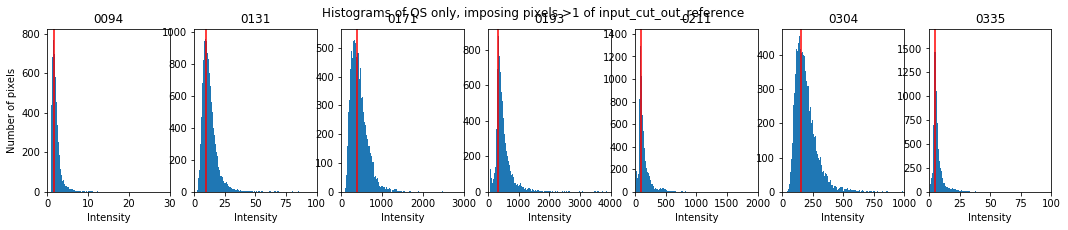

In [27]:
#testing the most frequent value in the original distribution of quiet_sun_AIA_reference[indices_no_zero[0],indices_no_zero[1]]
#we use argmax


bins_num = [50,200,500,1000,3000]

print('Histograms overlaid with most frequent values found with argmax')
fig, ax = plt.subplots(1, 7, figsize=(18,3), sharey=False)

for ch in range(len(channels)-1): #For each time, iterate over the AIA channels. The last channel is HMI so len(channels)-1.
    quiet_sun_AIA_reference = mask_qs_reference*input_cut_out_reference[ch,:,:].copy()
    print('channel',ch, 'max = ', np.max(quiet_sun_AIA_reference[indices_no_zero[0],indices_no_zero[1]]))
    indices_no_zero = np.where(quiet_sun_AIA_reference>1) #Considering the pixels without the zeros.
    peak_histo = np.argmax(quiet_sun_AIA_reference[indices_no_zero[0],indices_no_zero[1]])
    print(quiet_sun_AIA_reference[indices_no_zero[0],indices_no_zero[1]][peak_histo])
    for b in range(len(bins_num)): 
        print("b=", b, "bins_num=", bins_num[b])
        test_histo=np.histogram(quiet_sun_AIA_reference[indices_no_zero[0],indices_no_zero[1]], bins=bins_num[b])
                                        #, range=None, normed=None, weights=None, density=None)[source]
        print("where is the most frequent value", np.argmax(test_histo[0]))
        print("what is the most frequent value", test_histo[1][np.argmax(test_histo[0])])
    ax[ch].set_title(channels[ch])
    ax[ch].hist(x=pd.Series(np.ravel(quiet_sun_AIA_reference[indices_no_zero[0],indices_no_zero[1]])), bins=1000)
    ax[ch].set_xlabel('Intensity')
    ax[ch].set_xlim([0,xlimit[ch]])
    ax[ch].axvline(x=test_histo[1][np.argmax(test_histo[0])], color='red')
    ax[0].set_ylabel('Number of pixels');
fig.suptitle('Histograms of QS only, imposing pixels >1 of input_cut_out_reference')


Histograms overlaid with mode found from analytical relation
mode of channel 0 = 1.398729991750183
mode of channel 1 = 8.918662213748087
mode of channel 2 = 329.78720704578177
mode of channel 3 = 298.85676806098786
mode of channel 4 = 63.11866033670767
mode of channel 5 = 145.36294598787939
mode of channel 6 = 3.562634424448556


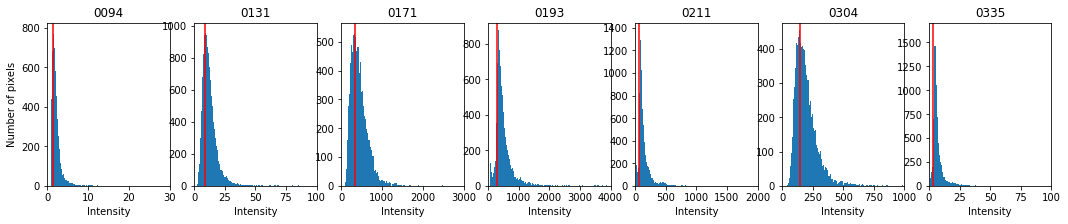

In [28]:
#Another way of figuring out: assuming that we have a log normal distribution:
#Then, the mode is given by the formula: mode = median**3 / mean**2

print('Histograms overlaid with mode found from analytical relation')
fig, ax = plt.subplots(1, 7, figsize=(18,3), sharey=False)

for ch in range(len(channels)-1): #For each time, iterate over the AIA channels. The last channel is HMI so len(channels)-1.
    quiet_sun_AIA_reference = mask_qs_reference*input_cut_out_reference[ch,:,:].copy()
    indices_no_zero = np.where(quiet_sun_AIA_reference>1) #Considering the pixels without the zeros.
    peak_histo = np.argmax(quiet_sun_AIA_reference[indices_no_zero[0],indices_no_zero[1]])
    mode_ana = np.median(quiet_sun_AIA_reference[indices_no_zero[0],indices_no_zero[1]])**3/np.mean(quiet_sun_AIA_reference[indices_no_zero[0],indices_no_zero[1]])**2
    print('mode of channel', ch, '=', mode_ana)

    ax[ch].set_title(channels[ch])
    ax[ch].hist(x=pd.Series(np.ravel(quiet_sun_AIA_reference[indices_no_zero[0],indices_no_zero[1]])), bins=1000)
    ax[ch].set_xlabel('Intensity')
    ax[ch].set_xlim([0,xlimit[ch]])
    ax[ch].axvline(x=mode_ana, color='red')
    ax[0].set_ylabel('Number of pixels');

mode_fit of channel 0 = 1.7020304609186716
most probable value of fit-pdf 0 = 1.705901967322441
mode_fit of channel 1 = 9.468190627855822
most probable value of fit-pdf 1 = 9.48382794264755
mode_fit of channel 2 = 329.6549836289643
most probable value of fit-pdf 2 = 330.0
mode_fit of channel 3 = 342.20672427185633
most probable value of fit-pdf 3 = 342.3617872624208
mode_fit of channel 4 = 87.29789458987639
most probable value of fit-pdf 4 = 86.98566188729576
mode_fit of channel 5 = 151.81465850710924
most probable value of fit-pdf 5 = 151.89929976658888
mode_fit of channel 6 = 4.7580571496652135
most probable value of fit-pdf 6 = 4.76325441813938


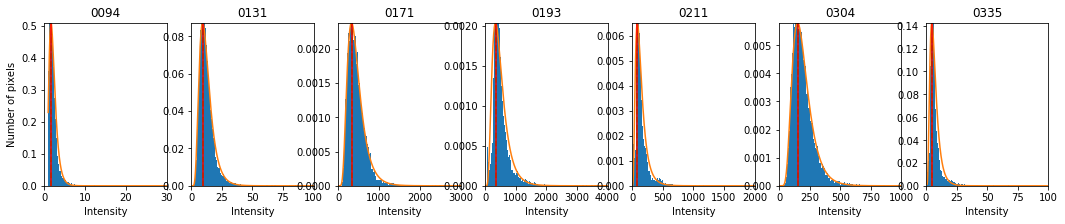

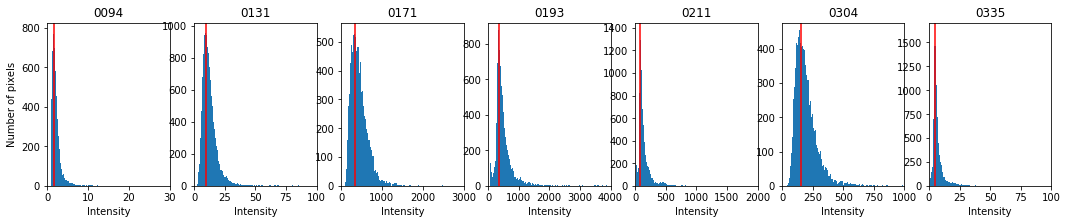

In [29]:
#Let's now try fitting with an analytical lognormal
#The fitting of the log-normal then can give us an analytical solution for the max of the fit.

most_probable_value_ref=np.zeros([7])
mode = np.zeros([7])

fig, ax = plt.subplots(1, 7, figsize=(18,3), sharey=False)

for ch in range(len(channels)-1): #For each time, iterate over the AIA channels. The last channel is HMI so len(channels)-1.
    quiet_sun_AIA_reference = mask_qs_reference*input_cut_out_reference[ch,:,:].copy()
    indices_no_zero = np.where(quiet_sun_AIA_reference>1) #Considering the pixels without the zeros.
    shape_ref,loc_ref,scale_ref = lognorm.fit(quiet_sun_AIA_reference[indices_no_zero[0],indices_no_zero[1]],floc=0)# Fitting a log normal distribution 
#    print(shape_ref,loc_ref,scale_ref)

    mode_fit = np.exp(np.log(scale_ref)-shape_ref**2)+loc_ref
    print('mode_fit of channel', ch, '=', mode_fit)    
    
    #getting the distribution from the log fit    
    intensity_reference=np.linspace(1,xlimit[ch], num=3000) # values for x-axis
    probability_qs_reference = lognorm.pdf(intensity_reference,shape_ref,0, scale_ref)
    #probability_qs_reference = lognorm.pdf(intensity_reference,shape_ref,loc_ref, scale_ref)
    most_probable_value_ref = intensity_reference[np.argmax(probability_qs_reference)]
    print('most probable value of fit-pdf', ch, '=', most_probable_value_ref)    

    #plotting 
    ymax = np.max(probability_qs_reference)
    ax[ch].set_title(channels[ch])
    ax[0].set_ylabel('Number of pixels');
    ax[ch].set_xlabel('Intensity')
    ax[ch].set_xlim([0,xlimit[ch]])
    ax[ch].set_ylim(0,ymax)
    ax[ch].hist(x=pd.Series(np.ravel(quiet_sun_AIA_reference[indices_no_zero[0],indices_no_zero[1]])), bins=1000, density=True)
    ax[ch].plot(intensity_reference, probability_qs_reference)
    ax[ch].axvline(x=mode_fit, color='red')
#    ax[ch].vlines(mode_fit, 0, probability_qs_reference.max(), linestyle=':', color='blue', label='Mode')
    ax[ch].vlines(most_probable_value_ref, 0, probability_qs_reference.max(), linestyle='--', color='green', label='Other Mode')



fig, ax = plt.subplots(1, 7, figsize=(18,3), sharey=False)

for ch in range(len(channels)-1): #For each time, iterate over the AIA channels. The last channel is HMI so len(channels)-1.
    quiet_sun_AIA_reference = mask_qs_reference*input_cut_out_reference[ch,:,:].copy()
    indices_no_zero = np.where(quiet_sun_AIA_reference>1) #Considering the pixels without the zeros.
    shape_ref,loc_ref,scale_ref = lognorm.fit(quiet_sun_AIA_reference[indices_no_zero[0],indices_no_zero[1]],floc=0)# Fitting a log normal distribution 
    mode_fit = np.exp(np.log(scale_ref)-shape_ref**2)+loc_ref
    ax[ch].set_title(channels[ch])
    ax[ch].hist(x=pd.Series(np.ravel(quiet_sun_AIA_reference[indices_no_zero[0],indices_no_zero[1]])), bins=1000)
    ax[ch].set_xlabel('Intensity')
    ax[ch].set_xlim([0,xlimit[ch]])
    ax[ch].axvline(x=mode_fit, color='red')
    ax[0].set_ylabel('Number of pixels');

In [ ]:
#Comparing all the methods above

In [17]:
#testing the most frequent value in the original distribution of quiet_sun_AIA_reference[indices_no_zero[0],indices_no_zero[1]]
#we use argmax

peak_ref=np.zeros([7])
mode_ref=np.zeros([7])

xlimit_plot = [20,70,750,750,500,500,60]

#xlimit_plot = [5,20,750,750,200,300,50]

fig, ax = plt.subplots(1, 7, figsize=(18,3), sharey=False)
print('Red is the peak of original histogram')
print('Blue is the analytical formulation of a log from parameters of original histogram') 
print('Cyan is the mode of the fitted distribution') 
print('Black is the peak of the histogram of the fitted distribution') 

for ch in range(len(channels)-1): 
    print(ch)
    quiet_sun_AIA_reference = mask_qs_reference*input_cut_out_reference[ch,:,:].copy()
    indices_no_zero = np.where(quiet_sun_AIA_reference>0.1) #Considering the pixels without the zeros.

    ax[0].set_ylabel('Number of pixels');
    ax[ch].set_title(channels[ch])
    ax[ch].set_xlabel('Intensity')
    ax[ch].set_xlim([0,xlimit_plot[ch]])
    ax[ch].hist(x=pd.Series(np.ravel(quiet_sun_AIA_reference[indices_no_zero[0],indices_no_zero[1]])), bins=3000)

    #Method 1
    test_histo=np.histogram(quiet_sun_AIA_reference[indices_no_zero[0],indices_no_zero[1]], bins=3000)
    print("Method 1", test_histo[1][np.argmax(test_histo[0])])
    ax[ch].axvline(x=test_histo[1][np.argmax(test_histo[0])], color='red')
    peak_ref[ch]=test_histo[1][np.argmax(test_histo[0])]
             
    #Method 2   
    mode_ana = np.median(quiet_sun_AIA_reference[indices_no_zero[0],indices_no_zero[1]])**3/np.mean(quiet_sun_AIA_reference[indices_no_zero[0],indices_no_zero[1]])**2
    print('Method 2', mode_ana)
    ax[ch].axvline(x=mode_ana, color='blue')

    #Method 3
    shape_ref,loc_ref,scale_ref = lognorm.fit(quiet_sun_AIA_reference[indices_no_zero[0],indices_no_zero[1]],floc=0)# Fitting a log normal distribution 
    mode_fit = np.exp(np.log(scale_ref)-shape_ref**2)+loc_ref
    print('Method 3', mode_fit)    
    ax[ch].axvline(x=mode_fit, color='green')
    mode_ref[ch]=mode_fit
    #Method 3.5
    intensity_reference=np.linspace(1,xlimit[ch], num=1000) # values for x-axis
#    probability_qs_reference = lognorm.pdf(intensity_reference,shape_ref, 0, scale_ref)
    probability_qs_reference = lognorm.pdf(intensity_reference,shape_ref,loc_ref, scale_ref)
    mode_fit_2 = intensity_reference[np.argmax(probability_qs_reference)]
    print('method 3.5', mode_fit_2)    
    ax[ch].axvline(x=mode_fit_2,  linestyle=':', color='black')

    #    ax[ch].vlines(mode_fit_2, 0, probability_qs_reference.max(),, color='black')
                  #, label='Mode')


Red is the peak of original histogram
Blue is the analytical formulation of a log from parameters of original histogram
Cyan is the mode of the fitted distribution
Black is the peak of the histogram of the fitted distribution
0
Method 1 1.7664738568266234
Method 2 1.348284836663522
Method 3 2.062431789213407
method 3.5 2.0740740740740744
1
Method 1 8.980959433237711
Method 2 7.007229995556225
Method 3 10.457399556737425
method 3.5 10.414414414414415
2
Method 1 245.989886332194
Method 2 211.28866978952172
Method 3 272.467585749757
method 3.5 271.1801801801802
3
Method 1 520.5544908955892
Method 2 376.467013839593
Method 3 463.34157315144455
method 3.5 461.3453453453453
4
Method 1 139.25720836639402
Method 2 145.1967843836044
Method 3 171.3132298991808
method 3.5 171.0850850850851
5
Method 1 151.37731771469117
Method 2 144.6494672729167
Method 3 165.37333557724125
method 3.5 165.0
6
Method 1 9.673325713475545
Method 2 5.577490400813113
Method 3 9.447496949082648
method 3.5 9.423423423423

KeyboardInterrupt: 

0
Method 3 2.062431789213407
1
Method 3 10.457399556737425
2
Method 3 272.467585749757
3
Method 3 463.34157315144455
4
Method 3 171.3132298991808
5
Method 3 165.37333557724125
6
Method 3 9.447496949082648


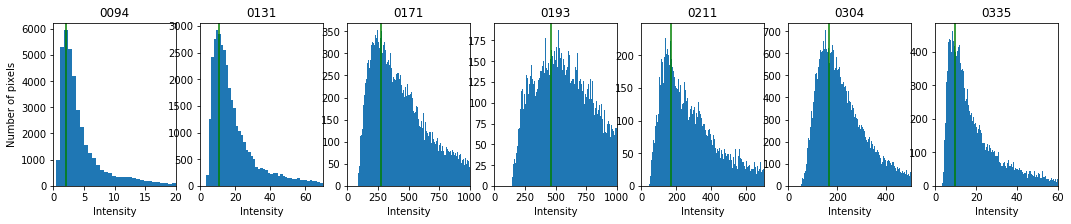

In [18]:
#Just with mode, for generating images for presentations

mode_ref=np.zeros([7])

xlimit_plot = [20,70,1000,1000,700,500,60]

fig, ax = plt.subplots(1, 7, figsize=(18,3), sharey=False)

for ch in range(len(channels)-1): 
    print(ch)
    quiet_sun_AIA_reference = mask_qs_reference*input_cut_out_reference[ch,:,:].copy()
    indices_no_zero = np.where(quiet_sun_AIA_reference>0.1) #Considering the pixels without the zeros.

    ax[0].set_ylabel('Number of pixels');
    ax[ch].set_title(channels[ch])
    ax[ch].set_xlabel('Intensity')
    ax[ch].set_xlim([0,xlimit_plot[ch]])
    ax[ch].hist(x=pd.Series(np.ravel(quiet_sun_AIA_reference[indices_no_zero[0],indices_no_zero[1]])), bins=3000)

 
    #Method 3
    shape_ref,loc_ref,scale_ref = lognorm.fit(quiet_sun_AIA_reference[indices_no_zero[0],indices_no_zero[1]],floc=0)# Fitting a log normal distribution 
    mode_fit = np.exp(np.log(scale_ref)-shape_ref**2)+loc_ref
    print('Method 3', mode_fit)    
    ax[ch].axvline(x=mode_fit, color='green')
    mode_ref[ch]=mode_fit
 

## Apply some dimming

In [27]:
t_index2 = t_index+100

In [21]:
dim_factor = np.zeros(7)
while any(dim_factor < 0.01):
    dim_factor = np.random.rand(7)

In [22]:
print(dim_factor)

[0.29911633 0.5056859  0.83538116 0.45470036 0.19970622 0.78346195
 0.80337689]


In [28]:
mask_qs=np.zeros((np.int(original_ratio/(2.*subsample)),np.int(original_ratio/(2.*subsample))),dtype=float) #This is the mask for the quiet sun. 
input_cut_out=input_data[t_index2,:,roi_cut_out[0]:roi_cut_out[1],roi_cut_out[2]:roi_cut_out[3]]
indices_threshold =np.where(np.abs(input_cut_out[7,:,:]) <= mag_threshold)
mask_qs[indices_threshold[0],indices_threshold[1]]=1 # Setting the pixels for the QS to 1


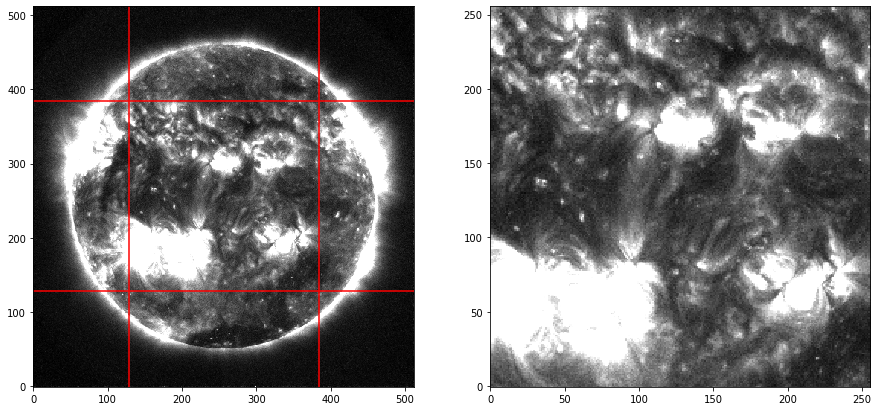

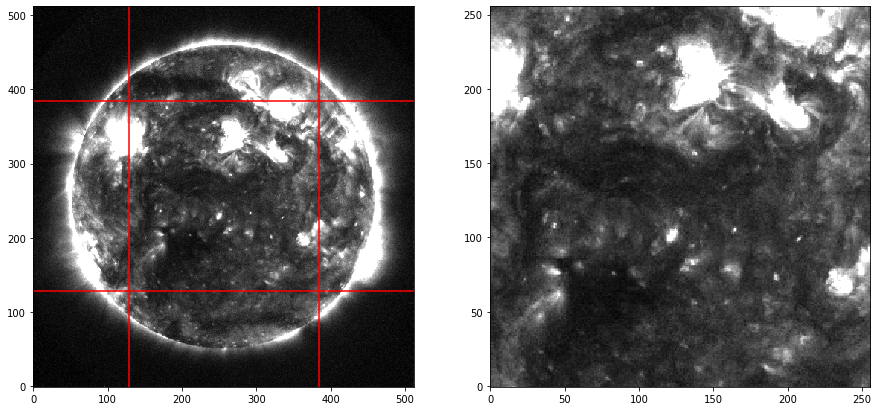

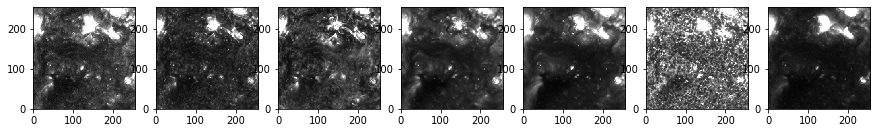

In [40]:
a0 = input_data[t_index2,0,:,:]
a1 = input_data[t_index2,1,:,:]
a2 = input_data[t_index2,2,:,:]
a3 = input_data[t_index2,3,:,:]
a4 = input_data[t_index2,4,:,:]
a5 = input_data[t_index2,5,:,:]
a6 = input_data[t_index2,6,:,:]
b0 = input_cut_out[0,:,:]
b1 = input_cut_out[1,:,:]
b2 = input_cut_out[2,:,:]
b3 = input_cut_out[3,:,:]
b4 = input_cut_out[4,:,:]
b5 = input_cut_out[5,:,:]
b6 = input_cut_out[6,:,:]
figsize=(15,15)
fig, ax = plt.subplots(1, 2, figsize=figsize, sharey=False)
ax[0].imshow(a, cmap='gray',clim=(0,10),origin='lower')
ax[0].axvline(x=xposmin, color='red')
ax[0].axvline(x=xposmax, color='red')
ax[0].axhline(y=yposmin, color='red')
ax[0].axhline(y=yposmax, color='red')
ax[1].imshow(b, cmap='gray',clim=(0,10), origin='lower')

fig, ax = plt.subplots(1, 2, figsize=figsize, sharey=False)
ax[0].imshow(a0, cmap='gray',clim=(0,10),origin='lower')
ax[0].axvline(x=xposmin, color='red')
ax[0].axvline(x=xposmax, color='red')
ax[0].axhline(y=yposmin, color='red')
ax[0].axhline(y=yposmax, color='red')
ax[1].imshow(b0, cmap='gray',clim=(0,10), origin='lower')

fig, ax = plt.subplots(1, 7, figsize=figsize, sharey=False)
ax[0].imshow(b0, cmap='gray',clim=(0,10),origin='lower')
ax[1].imshow(b1, cmap='gray',clim=(0,80), origin='lower')
ax[2].imshow(b2, cmap='gray',clim=(0,2000), origin='lower')
ax[3].imshow(b3, cmap='gray',clim=(0,3000), origin='lower')
ax[4].imshow(b4, cmap='gray',clim=(0,1000), origin='lower')
ax[5].imshow(b5, cmap='gray',clim=(0,500), origin='lower')
ax[6].imshow(b6, cmap='gray',clim=(0,80), origin='lower')


0
1
2
3
4
5
6


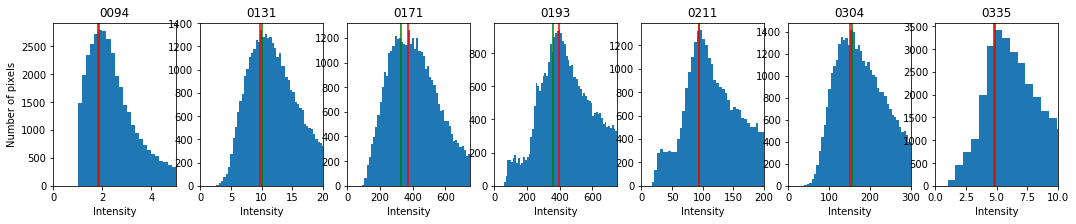

In [54]:
xlimit_plot = [5,20,750,750,200,300,10]
mode=np.zeros([7])
peak=np.zeros([7])
fig, ax = plt.subplots(1, 7, figsize=(18,3), sharey=False)

for ch in range(len(channels)-1): 
    print(ch)
    quiet_sun_AIA = mask_qs*input_cut_out[ch,:,:].copy()
    indices_no_zero = np.where(quiet_sun_AIA>0.1) #Considering the pixels without the zeros.

    ax[0].set_ylabel('Number of pixels');
    ax[ch].set_title(channels[ch])
    ax[ch].set_xlabel('Intensity')
    ax[ch].set_xlim([0,xlimit_plot[ch]])
    ax[ch].hist(x=pd.Series(np.ravel(quiet_sun_AIA[indices_no_zero[0],indices_no_zero[1]])), bins=1000)

    shape_ref,loc_ref,scale_ref = lognorm.fit(quiet_sun_AIA[indices_no_zero[0],indices_no_zero[1]],floc=0)# Fitting a log normal distribution 
    mode_fit = np.exp(np.log(scale_ref)-shape_ref**2)+loc_ref
    ax[ch].axvline(x=mode_fit, color='green')
    mode[ch]=mode_fit
    
    test_histo=np.histogram(quiet_sun_AIA[indices_no_zero[0],indices_no_zero[1]], bins=1000)
    ax[ch].axvline(x=test_histo[1][np.argmax(test_histo[0])], color='red')
    peak[ch]=test_histo[1][np.argmax(test_histo[0])]
             

In [23]:
alpha_pred = np.zeros(7)
alpha_gt = np.zeros(7)

alpha_gt[:] = dim_factor

0
1
2
3
4
5
6
How well are we doing dimmed image to reference
0.5907984022325494 0.6676555494429761 -0.07685714721042669
0.17642630465571407 0.20942219439025167 -0.0329958897345376
0.7592033964929403 0.8321359665973537 -0.07293257010441334
0.26857515828732387 0.44371573228028327 -0.1751405739929594
0.06430456549581356 0.12653843982616209 -0.06223387433034852
0.748265717518586 0.8166571010756066 -0.06839138355702068
0.17703116550583034 0.21947456890601713 -0.04244340340018679

How well are we doing dimmed image to same undimmed image
0.7911675029837356 0.6676555494429761 0.1235119535407595
0.21352265536794576 0.20942219439025167 0.004100460977694093
0.8321357774409758 0.8321359665973537 -1.891563778944061e-07
0.4437156938097847 0.44371573228028327 -3.847049856453566e-08
0.12653844743160705 0.12653843982616209 7.605444968250552e-09
0.816656866712495 0.8166571010756066 -2.3436311158420153e-07
0.28208989105600196 0.21947456890601713 0.06261532214998483

How well are we doing dimmed image t

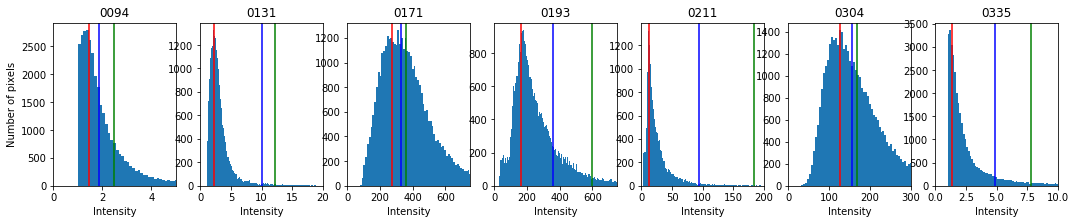

In [59]:
mode_dim=np.zeros([7])
peak_dim=np.zeros([7])
xlimit_plot = [5,20,750,750,200,300,10]


alpha_pred_samet = np.zeros(7)
alpha_pred_peak = np.zeros(7)

fig, ax = plt.subplots(1, 7, figsize=(18,3), sharey=False)

for ch in range(len(channels)-1): #For each time, iterate over the AIA channels. The last channel is HMI so len(channels)-1.        
    print(ch)
    # The same process but now for the artificially dimmed image.
    dim_input_data = dim_factor[ch]*input_cut_out[ch,:,:]
    intensity_mask = dim_input_data*mask_qs>=0.1
    
    indices_no_zero_dim = np.where(intensity_mask)
    shape_dim,loc_dim,scale_dim = lognorm.fit(dim_input_data[indices_no_zero_dim[0],indices_no_zero_dim[1]],floc=0)
    mode_dim[ch] = np.exp(np.log(scale_dim)-shape_dim**2)+loc_dim

    test_histo=np.histogram(dim_input_data[indices_no_zero_dim[0],indices_no_zero_dim[1]], bins=1000)
    peak_dim[ch]=test_histo[1][np.argmax(test_histo[0])]

    ax[0].set_ylabel('Number of pixels');
    ax[ch].set_title(channels[ch])
    ax[ch].set_xlabel('Intensity')
    ax[ch].set_xlim([0,xlimit_plot[ch]])
    ax[ch].hist(x=pd.Series(np.ravel(dim_input_data[indices_no_zero_dim[0],indices_no_zero_dim[1]])), bins=1000)

    ax[ch].axvline(x=mode_dim[ch], color='red')
    ax[ch].axvline(x=mode_ref[ch], color='green')
    ax[ch].axvline(x=mode[ch], color='blue')

#    ax[ch].axvline(x=peak_dim[ch], color='pink')
#    ax[ch].axvline(x=peak_ref[ch], color='cyan')
#    ax[ch].axvline(x=peak[ch], color='black')

    dim_factor_pred = mode_dim[ch]/mode_ref[ch]
    alpha_pred[ch]  = dim_factor_pred  

    dim_factor_pred_samet = mode_dim[ch]/mode[ch]
    alpha_pred_samet[ch]  = dim_factor_pred_samet
   
    dim_factor_pred_peak  = peak_dim[ch]/peak_ref[ch]
    alpha_pred_peak[ch]   = dim_factor_pred_peak
    

print("How well are we doing dimmed image to reference")
for ch in range(len(channels)-1):
        print(alpha_pred[ch],alpha_gt[ch],alpha_pred[ch]-alpha_gt[ch])
print("")
print("How well are we doing dimmed image to same undimmed image")
for ch in range(len(channels)-1):
        print(alpha_pred_samet[ch],alpha_gt[ch],alpha_pred_samet[ch]-alpha_gt[ch])
print("")
print("How well are we doing dimmed image to reference, using the peak")
for ch in range(len(channels)-1):
        print(alpha_pred_peak[ch],alpha_gt[ch],alpha_pred_peak[ch]-alpha_gt[ch])

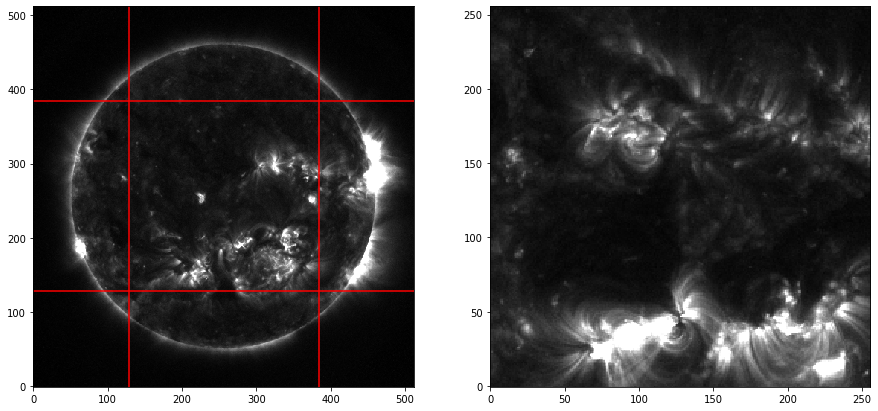

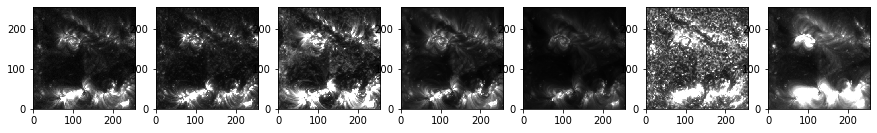

In [24]:
#images for presentation
a = input_data[t_index+100,0,:,:]*alpha_gt[0]
b = input_cut_out_reference[0,:,:]*alpha_gt[0]
b1 = input_cut_out_reference[1,:,:]*alpha_gt[1]
b2 = input_cut_out_reference[2,:,:]*alpha_gt[2]
b3 = input_cut_out_reference[3,:,:]*alpha_gt[3]
b4 = input_cut_out_reference[4,:,:]*alpha_gt[4]
b5 = input_cut_out_reference[5,:,:]*alpha_gt[5]
b6 = input_cut_out_reference[6,:,:]*alpha_gt[6]

figsize=(15,15)
fig, ax = plt.subplots(1, 2, figsize=figsize, sharey=False)
ax[0].imshow(a, cmap='gray',clim=(0,10),origin='lower')
ax[0].axvline(x=xposmin, color='red')
ax[0].axvline(x=xposmax, color='red')
ax[0].axhline(y=yposmin, color='red')
ax[0].axhline(y=yposmax, color='red')
ax[1].imshow(b, cmap='gray',clim=(0,10), origin='lower')


fig, ax = plt.subplots(1, 7, figsize=figsize, sharey=False)
ax[0].imshow(b, cmap='gray',clim=(0,10),origin='lower')
ax[1].imshow(b1, cmap='gray',clim=(0,80), origin='lower')
ax[2].imshow(b2, cmap='gray',clim=(0,2000), origin='lower')
ax[3].imshow(b3, cmap='gray',clim=(0,3000), origin='lower')
ax[4].imshow(b4, cmap='gray',clim=(0,1000), origin='lower')
ax[5].imshow(b5, cmap='gray',clim=(0,500), origin='lower')
ax[6].imshow(b6, cmap='gray',clim=(0,80), origin='lower')


0
1
2
3
4
5
6


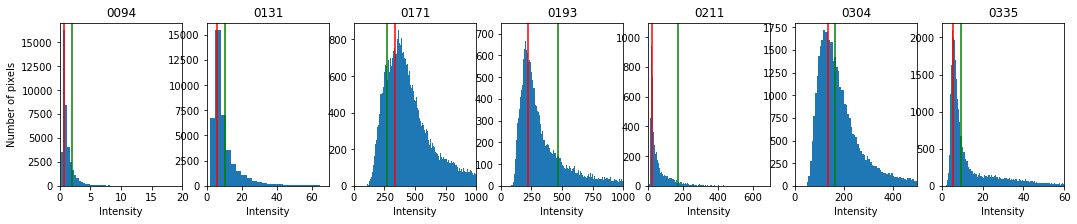

In [31]:
#Just with mode, for generating images for presentations
mode_dim=np.zeros([7])

xlimit_plot = [20,70,1000,1000,700,500,60]

fig, ax = plt.subplots(1, 7, figsize=(18,3), sharey=False)

for ch in range(len(channels)-1): #For each time, iterate over the AIA channels. The last channel is HMI so len(channels)-1.        
    print(ch)
    # The same process but now for the artificially dimmed image.
    dim_input_data = dim_factor[ch]*input_cut_out[ch,:,:]
    intensity_mask = dim_input_data*mask_qs>=0.1
    
    indices_no_zero_dim = np.where(intensity_mask)
    shape_dim,loc_dim,scale_dim = lognorm.fit(dim_input_data[indices_no_zero_dim[0],indices_no_zero_dim[1]],floc=0)
    mode_dim[ch] = np.exp(np.log(scale_dim)-shape_dim**2)+loc_dim

    ax[0].set_ylabel('Number of pixels');
    ax[ch].set_title(channels[ch])
    ax[ch].set_xlabel('Intensity')
    ax[ch].set_xlim([0,xlimit_plot[ch]])
    ax[ch].hist(x=pd.Series(np.ravel(dim_input_data[indices_no_zero_dim[0],indices_no_zero_dim[1]])), bins=1000)

    ax[ch].axvline(x=mode_dim[ch], color='red')
    ax[ch].axvline(x=mode_ref[ch], color='green')